In [1]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dropout,Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import operator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img_width, img_height = 150, 150  

train_data_dir = '../dataset/split_data/train/'
validation_data_dir = '../dataset/split_data/validation/'
top_model_weights_path = 'bottleneck_fc_model.h5'
nb_train_samples = 13447
nb_validation_samples = 4487
nb_classes = 10
epochs = 3
batch_size = 16

In [3]:
def save_bottleneck_features():

    model = applications.VGG16(include_top=False, weights='imagenet')  
    datagen = ImageDataGenerator(rescale=1. / 255)  

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), \
                                            batch_size=batch_size, class_mode=None, shuffle=False)  

    n_train_samples = len(generator.filenames)  
    n_classes = len(generator.class_indices)
    print("Number of train files = {}".format(n_train_samples))
    print("Number of classes = {}".format(n_classes))

    predict_size_train = int(math.ceil(n_train_samples / batch_size))  

    bottleneck_features_train = model.predict_generator(generator, predict_size_train, verbose=1)  

    np.save('bottleneck_features_train.npy', bottleneck_features_train) 

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), \
     batch_size=batch_size, class_mode=None, shuffle=False)  

    n_validation_samples = len(generator.filenames)  

    predict_size_validation = int(math.ceil(n_validation_samples / batch_size))  

    bottleneck_features_validation = model.predict_generator(generator, predict_size_validation, verbose=1)  

    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)  



In [4]:
def create_top_model(final_activation,input_shape):
    model = Sequential()  
    model.add(Flatten(input_shape=input_shape))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(nb_classes, activation=final_activation)) # sigmoid to train, softmax for prediction
    return model

In [5]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1./255)  
    generator_top = datagen_top.flow_from_directory(train_data_dir, target_size=(img_width, img_height),\
                                                    batch_size=batch_size, class_mode='categorical', \
                                                    shuffle=False)  

    n_train_samples = len(generator_top.filenames)  
    n_classes = len(generator_top.class_indices)  

    # load the bottleneck features saved earlier  
    train_data = np.load('bottleneck_features_train.npy')  

    # get the class lebels for the training data, in the original order  
    train_labels = generator_top.classes  

    # convert the training labels to categorical vectors  
    train_labels = to_categorical(train_labels, num_classes=n_classes)

    generator_top = datagen_top.flow_from_directory(validation_data_dir, target_size=(img_width, img_height),\
                                                    batch_size=batch_size, class_mode=None, shuffle=False)  

    n_validation_samples = len(generator_top.filenames)  

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes  
    validation_labels = to_categorical(validation_labels, num_classes=n_classes)

    model = create_top_model("sigmoid",train_data.shape[1:])

    model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  

    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,\
                        validation_data=(validation_data, validation_labels))  

    model.save_weights(top_model_weights_path)  

    (eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, \
                                                batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss))
    return model


In [6]:
def get_prediction_from_image(img_path):
    
    class_labels = ['safe_driving', 'texting_right', 'talking_on_phone_right', 'texting_left', 'talking_on_phone_left',
                'operating_radio', 'drinking', 'reaching_behind', 'doing_hair_makeup', 'talking_to_passanger']

    target_size=(150,150)

    # prepare image for classification using keras utility functions
    image = load_img(img_path, target_size=target_size)
    
    # print image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    image = img_to_array(image) # convert from PIL Image to NumPy array
    image /= 255
    # the dimensions of image should now be (150, 150, 3)

    # to be able to pass it through the network and use batches, we want it with shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    # print(image.shape)

    # build the VGG16 network  
    model = applications.VGG16(include_top=False, weights='imagenet')  

    # get the bottleneck prediction from the pre-trained VGG16 model  
    bottleneck_prediction = model.predict(image) 
    
    # build top model  
    model = create_top_model("softmax",bottleneck_prediction.shape[1:])

    model.load_weights(top_model_weights_path)  

    # use the bottleneck prediction on the top model to get the final classification  
    class_predicted = model.predict_classes(bottleneck_prediction) 
    
    probs = model.predict(bottleneck_prediction) 
    decoded_predictions = dict(zip(class_labels, probs[0]))
    decoded_predictions = sorted(decoded_predictions.items(), key=operator.itemgetter(1), reverse=True)
    
    count = 1
    for key, value in decoded_predictions[:5]:
        print("{}. {}: {:8f}%".format(count, key, value*100))
        count+=1

    # print(class_predicted)
    # print(probs)

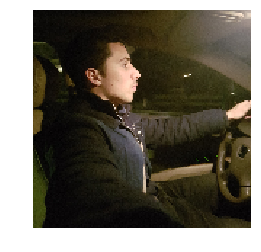

1. reaching_behind: 99.999809%
2. operating_radio: 0.000144%
3. drinking: 0.000049%
4. talking_on_phone_right: 0.000003%
5. talking_to_passanger: 0.000001%


In [12]:
# img_path = "../dataset/split_data/test/c5/img_18411.jpg"
img_path = "../src/keras/base/elias/20171208_001059.jpg"

if __name__ == "__main__":
    #save_bottleneck_features() # Takes a lot of time
    # model = train_top_model()
    get_prediction_from_image(img_path)